In [1]:
import pandas as pd
from pathlib import Path
from shutil import copy
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
import torch

#ONLY USE BELOW CODE IF USING GPU FOR ADDITONAL HORSEPOWER
print(torch.cuda.is_available())  # Should print True if GPU is enabled
print(torch.cuda.get_device_name(0))  # Shows the name of your GPU

True
NVIDIA GeForce RTX 3070


## Create training and valid sets to test on

In [4]:
#Split test and train data randomly for red and blue ovals
source_folder = Path('training data')
classes = [folder.name for folder in source_folder.iterdir() if folder.is_dir() and folder.name not in ['train', 'valid', 'models']]


for cls in classes:
    img_path = source_folder / cls
    images = list(img_path.iterdir())
    
    # Split into train and valid
    train_imgs, valid_imgs = train_test_split(images, test_size=0.2, random_state=42)

    # Create target folders
    (source_folder / 'train' / cls).mkdir(parents=True, exist_ok=True)
    (source_folder / 'valid' / cls).mkdir(parents=True, exist_ok=True)

    # Move images
    for img in train_imgs:
        shutil.copy(str(img), str(source_folder / 'train' / cls / img.name))
    for img in valid_imgs:
        shutil.copy(str(img), str(source_folder / 'valid' / cls / img.name))



## Loads in test data, create model and choose algorithm

In [8]:
#Load tested data
dls = ImageDataLoaders.from_folder(
    source_folder, 
    train='train', 
    valid='valid',
    num_workers=12, #Sets CPU to use 12 cores (I am using a Ryzen 9 5900X with 12 cores) 
    bs=64, #Sets batch size to bs to leverage GPU in processing by increasing batch size, or decreasing if VRAM runs out
    pin_memory=True #Improves data transfer between CPU and GPU
) 
#, item_tfms=Resize(224)) #Resize images (speeds up model but decreases accuracy because image looks worse)

In [9]:
#Create model
learn = vision_learner(dls, resnet34, metrics=accuracy)

## Find optimal learning rate

SuggestedLRs(valley=0.0012022644514217973)


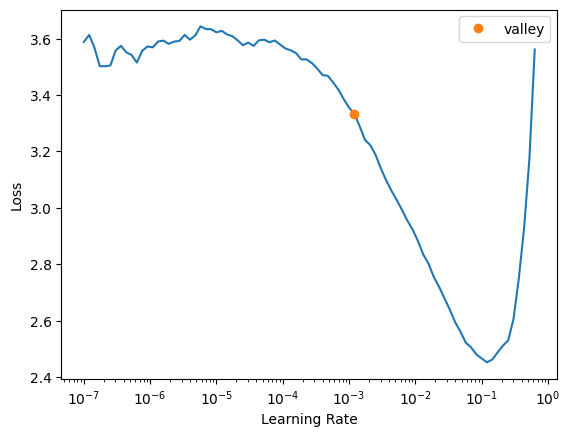

In [10]:
#Find optimal learning value
#Unused in this model
optimal_model = learn.lr_find()
print(optimal_model)
optimal_rate = optimal_model[0]

## Fine tune model

In [11]:
#Fine tune
learn.fine_tune(
    8, 
    cbs=[
        EarlyStoppingCallback(monitor='valid_loss', patience=2), #Stops training epochs if valid_loss begins dropping
        SaveModelCallback(monitor='valid_loss', fname='best_model') #Saves the best model if training stops
    ],
    base_lr = optimal_rate)

epoch,train_loss,valid_loss,accuracy,time
0,1.378045,0.811745,0.720748,04:08


Better model found at epoch 0 with valid_loss value: 0.8117448091506958.


epoch,train_loss,valid_loss,accuracy,time
0,0.547978,0.316743,0.892767,06:32
1,0.319272,0.258095,0.912594,06:51
2,0.199165,0.249425,0.920972,09:43
3,0.131561,0.247736,0.930466,14:41
4,0.066915,0.221468,0.938844,06:22
5,0.022848,0.197189,0.948059,06:19
6,0.009537,0.200915,0.951689,06:19
7,0.006750,0.202097,0.952248,06:19


Better model found at epoch 0 with valid_loss value: 0.31674328446388245.
Better model found at epoch 1 with valid_loss value: 0.25809451937675476.
Better model found at epoch 2 with valid_loss value: 0.24942456185817719.
Better model found at epoch 3 with valid_loss value: 0.2477356195449829.
Better model found at epoch 4 with valid_loss value: 0.22146837413311005.
Better model found at epoch 5 with valid_loss value: 0.19718945026397705.
No improvement since epoch 5: early stopping


In [12]:
#Evaluate
learn.validate()

(#2) [0.19718945026397705,0.9480592012405396]

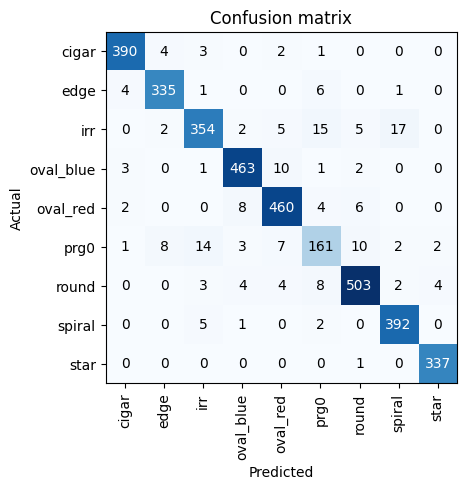

In [13]:
#Evaluate model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


## Create model like before but using convnext-tiny

In [6]:
#Create model
learn = vision_learner(dls, convnext_tiny, metrics=accuracy)

C:\Users\evnpu\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\evnpu\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
#Find optimal learning value
optimal_model = learn.lr_find()
print(optimal_model)
optimal_rate = optimal_model[0]

KeyboardInterrupt: 

In [16]:
#Fine tune
learn.fine_tune(
    8, 
    cbs=[
        EarlyStoppingCallback(monitor='valid_loss', patience=2), #Stops training epochs if valid_loss begins dropping
        SaveModelCallback(monitor='valid_loss', fname='best_model') #Saves the best model if training stops
    ],
    base_lr = optimal_rate)

epoch,train_loss,valid_loss,accuracy,time
0,0.841933,0.369211,0.879084,03:22


Better model found at epoch 0 with valid_loss value: 0.36921095848083496.


epoch,train_loss,valid_loss,accuracy,time
0,0.507653,0.248837,0.921530,15:59
1,0.383626,0.186443,0.941357,14:40
2,0.271891,0.151716,0.953923,14:34
3,0.212504,0.151509,0.955320,14:33
4,0.184996,0.128594,0.962301,14:34
5,0.141534,0.116364,0.966490,14:34
6,0.120014,0.112762,0.968724,14:33
7,0.119975,0.112204,0.969003,14:33


Better model found at epoch 0 with valid_loss value: 0.24883702397346497.
Better model found at epoch 1 with valid_loss value: 0.18644297122955322.
Better model found at epoch 2 with valid_loss value: 0.1517164558172226.
Better model found at epoch 3 with valid_loss value: 0.15150891244411469.
Better model found at epoch 4 with valid_loss value: 0.12859377264976501.
Better model found at epoch 5 with valid_loss value: 0.11636364459991455.
Better model found at epoch 6 with valid_loss value: 0.11276205629110336.
Better model found at epoch 7 with valid_loss value: 0.11220443248748779.


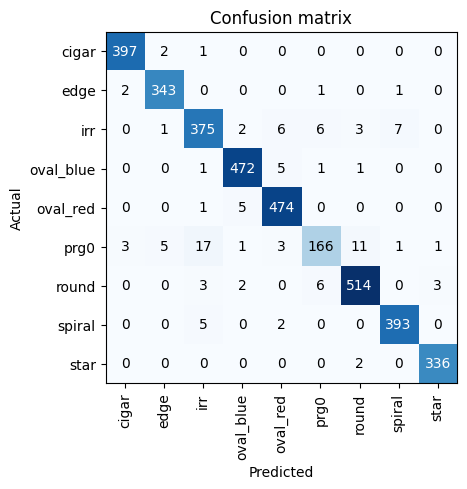

In [17]:
#Evaluate model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


# Convnext-tiny review
This model looks very good, and could probably use more epochs to see if accuracy will go any higher. 8 looks like it might be the peak but it wouldn't hurt to try 10-12.

## Convnext-tiny again with 12 epochs

In [22]:
#Load tested data
dls = ImageDataLoaders.from_folder(
    source_folder, 
    train='train', 
    valid='valid',
    num_workers=12, #Sets CPU to use 12 cores (I am using a Ryzen 9 5900X with 12 cores) 
    bs=64, #Sets batch size to bs to leverage GPU in processing by increasing batch size, or decreasing if VRAM runs out
    pin_memory=True #Improves data transfer between CPU and GPU
) 
#, item_tfms=Resize(224)) #Resize images (speeds up model but decreases accuracy because image looks worse)

In [23]:
#Create model
learn = vision_learner(dls, convnext_tiny, metrics=accuracy)

SuggestedLRs(valley=0.0010000000474974513)


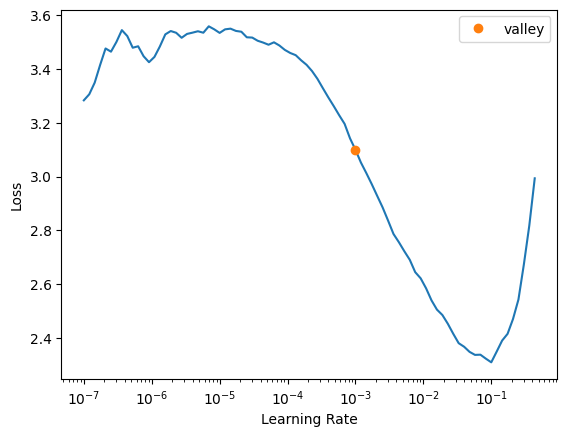

In [24]:
#Find optimal learning value
optimal_model = learn.lr_find()
print(optimal_model)
optimal_rate = optimal_model[0]

In [25]:
#Fine tune
learn.fine_tune(
    12, 
    cbs=[
        EarlyStoppingCallback(monitor='valid_loss', patience=2), #Stops training epochs if valid_loss begins dropping
        SaveModelCallback(monitor='valid_loss', fname='best_model') #Saves the best model if training stops
    ],
    base_lr = optimal_rate)

epoch,train_loss,valid_loss,accuracy,time
0,0.869854,0.379429,0.870148,10:38


Better model found at epoch 0 with valid_loss value: 0.37942904233932495.


epoch,train_loss,valid_loss,accuracy,time
0,0.518990,0.262511,0.915945,31:33
1,0.397697,0.196023,0.935493,31:34
2,0.306473,0.181528,0.939961,31:29
3,0.243580,0.138935,0.957833,31:15
4,0.190448,0.126336,0.960626,31:10
5,0.156860,0.125663,0.962580,31:10
6,0.136250,0.119839,0.966211,31:11
7,0.112715,0.110984,0.967048,31:10
8,0.106298,0.106815,0.970120,31:35
9,0.092167,0.103550,0.971237,31:50


Better model found at epoch 0 with valid_loss value: 0.2625109851360321.
Better model found at epoch 1 with valid_loss value: 0.1960226595401764.
Better model found at epoch 2 with valid_loss value: 0.18152762949466705.
Better model found at epoch 3 with valid_loss value: 0.13893452286720276.
Better model found at epoch 4 with valid_loss value: 0.12633563578128815.
Better model found at epoch 5 with valid_loss value: 0.12566304206848145.
Better model found at epoch 6 with valid_loss value: 0.11983946710824966.
Better model found at epoch 7 with valid_loss value: 0.11098414659500122.
Better model found at epoch 8 with valid_loss value: 0.10681499540805817.
Better model found at epoch 9 with valid_loss value: 0.10354982316493988.
No improvement since epoch 9: early stopping


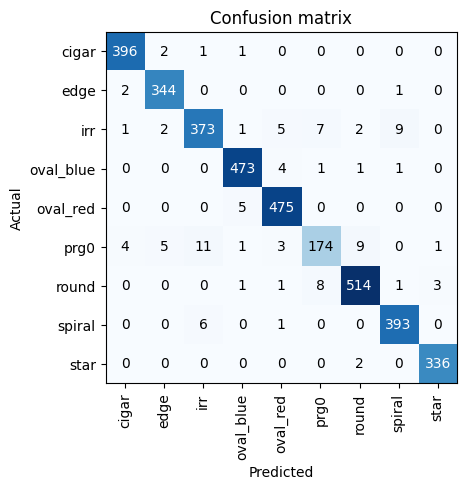

In [26]:
#Evaluate model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [27]:
#Save classifier
learn.export('full_model1.pkl')

# Run model on full dataset

In [14]:
#Recreate Dataloader
# source_folder = Path('training data')
# dls = ImageDataLoaders.from_folder(
#     source_folder, 
#     train='train', 
#     valid='valid',
#     num_workers=12, #Sets CPU to use 12 cores (I am using a Ryzen 9 5900X with 12 cores) 
#     bs=64, #Sets batch size to bs to leverage GPU in processing by increasing batch size, or decreasing if VRAM runs out
#     pin_memory=True #Improves data transfer between CPU and GPU
# ) 

#Load in learner
learn = load_learner('full_model1.pkl')
dls = learn.dls
print("Model loaded.")

Model loaded.


In [29]:
#Path to large dataset
# full_dataset = Path('ims')
full_dataset = Path('small_test_ims')
image_files = list(full_dataset.iterdir())

test_dls = learn.dls.test_dl(image_files, bs=256, num_workers=24, pin_memory=True)

In [30]:
learn.to(torch.device('cuda'))

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06,

In [31]:
#THIS ONE TO FIND GPU BOTTLENECK
with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./log')
) as prof:
    preds, _ = learn.get_preds(dl=test_dls)

print(prof.key_averages().table(sort_by="cuda_time_total"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::linear         0.03%       3.987ms        71.00%        9.374s     246.672ms       1.730ms         0.01%        9.374s     246.682ms            38  
                                           aten::matmul         0.03%       4.422ms        64.85%        8.561s     225.302ms       2.303ms         0.02%        8.562s     225.316ms            38  
         

In [22]:
# Get predictions for the entire dataset
preds, _ = learn.get_preds(dl=test_dls)

# Convert predictions (logits) to probabilities
probabilities = preds.softmax(dim=1)  # Applies softmax to get class probabilities

# Save probabilities along with class predictions
predicted_classes = [learn.dls.vocab[i] for i in probabilities.argmax(dim=1)]
probs_list = probabilities.tolist()  # Convert tensor to a Python list


In [35]:
from PIL import Image

# Path to your dataset
dataset_path = Path('ims_test')

# Check all image files in the folder
for img_path in dataset_path.iterdir():
    try:
        # Try to open the image
        img = Image.open(img_path)
        img.verify()  # Verify integrity
    except Exception as e:
        print(f"Corrupted file: {img_path}, Error: {e}")

Corrupted file: ims_test\5514359.png, Error: Truncated File Read
Corrupted file: ims_test\5517761.png, Error: Truncated File Read


In [36]:
# List of corrupted file paths
corrupted_files = [
    Path('ims_test/5514359.png'),
    Path('ims_test/5517761.png')
]

# Delete the files
for file_path in corrupted_files:
    if file_path.exists():
        file_path.unlink()  # Removes the file
        print(f"Deleted: {file_path}")
    else:
        print(f"File not found: {file_path}")

Deleted: ims_test\5514359.png
Deleted: ims_test\5517761.png


## Create catalog

In [24]:
# Create a DataFrame with filenames, predicted classes, and probabilities
filenames = [f.name for f in full_dataset.iterdir() if f.is_file()]

# Combine all data into a table
catalog = pd.DataFrame({
    'filename': filenames,
    'predicted_class': predicted_classes,
    'probabilities': probs_list  # This contains a list of probabilities for all classes
})

# Save to a CSV file
catalog.to_csv('catalog_with_probabilities.csv', index=False)
print("Catalog saved as catalog_with_probabilities.csv")

Catalog saved as catalog_with_probabilities.csv


In [28]:
# Load the CSV file
catalog = pd.read_csv('catalog_with_probabilities.csv')

# Split the 'probabilities' column into separate columns
prob_columns = pd.DataFrame(catalog['probabilities'].apply(eval).tolist())

# Add the probability columns to the original DataFrame
for i, label in enumerate(learn.dls.vocab):  # Use vocab to name columns based on class labels
    catalog[label + '_pr'] = prob_columns[i]

# Drop the original 'probabilities' column if no longer needed
catalog.drop(columns=['probabilities'], inplace=True)

# Save the updated DataFrame back to a new CSV
catalog.to_csv('catalog_with_split_probabilities.csv', index=False)
print("Updated catalog saved as catalog_with_split_probabilities.csv")


Updated catalog saved as catalog_with_split_probabilities.csv
